In [1]:
from Mask_RCNN_Detect import Mask_RCNN_Detect

Using TensorFlow backend.


In [2]:
weights = 'weights/epoch55.h5'
mrcnn = Mask_RCNN_Detect(weights)

W0907 09:18:14.061990 4538312128 deprecation_wrapper.py:119] From /Applications/anaconda3/envs/Salus/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0907 09:18:14.076632 4538312128 deprecation_wrapper.py:119] From /Applications/anaconda3/envs/Salus/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0907 09:18:14.079961 4538312128 deprecation_wrapper.py:119] From /Applications/anaconda3/envs/Salus/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0907 09:18:14.101498 4538312128 deprecation_wrapper.py:119] From /Applications/anaconda3/envs/Salus/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please us

Loading weights from  weights/epoch55.h5


In [3]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [4]:
%matplotlib inline

In [5]:
files = os.listdir('default_images/'); files

['tmp.PNG', 'default_window.jpeg']

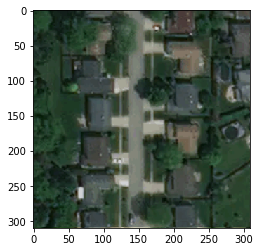

In [6]:
im = plt.imread('default_images/tmp.PNG')
plt.imshow(im)

In [7]:
im.shape

(310, 309, 4)

In [8]:
big_im = np.zeros((im.shape[0] * 2, im.shape[1] * 2, im.shape[2]))

for i in range(2):
    for j in range(2):
        start_h = im.shape[0] * i
        end_h = start_h + im.shape[0]
        
        start_w = im.shape[1] * j
        end_w = start_w + im.shape[1]
        
        big_im[start_h:end_h, start_w:end_w, :] = im

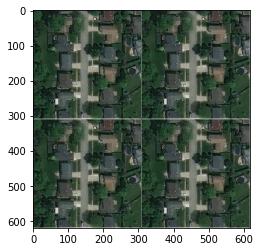

In [9]:
plt.imshow(big_im)

In [10]:
out = mrcnn.detect_building(im[:,:,:3], rectanglify=True, to_fill=True)

In [9]:
out.shape

(310, 309)

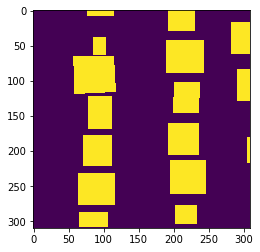

In [10]:
plt.imshow(out)

In [10]:
out = mrcnn.detect_building(big_im[:,:,:3], rectanglify=True, to_fill=True)

0 0
0 310 0 309
0 1
0 310 309 617
0 2
0 310 617 927
1 0
310 619 0 309
1 1
310 619 309 617
1 2
310 619 617 927
2 0
619 930 0 309
2 1
619 930 309 617
2 2
619 930 617 927


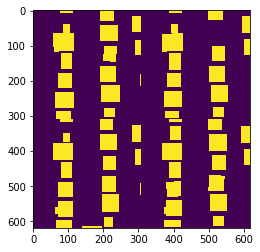

In [11]:
plt.imshow(out)